In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

In [ ]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [ ]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

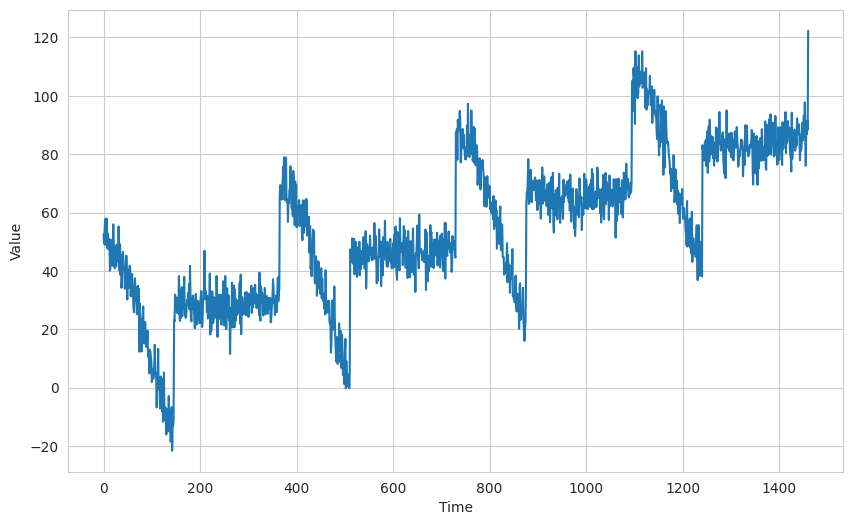

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [ ]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [ ]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [ ]:
train_set = window_dataset(X_train,window_size,batch_size=128)

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences= True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [ ]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 94ms/step - loss: 136.1005 - mae: 136.6005 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 49ms/step - loss: 89.6890 - mae: 90.1877 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 46ms/step - loss: 58.2108 - mae: 58.7072 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 44ms/step - loss: 51.4361 - mae: 51.9356 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 48ms/step - loss: 42.1636 - mae: 42.6623 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 48ms/step - loss: 33.7553 - mae: 34.2539 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 44ms/step - loss: 32.3573 - mae: 32.8551 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 47ms/step - loss: 25.8379 - mae: 26.3340 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 45ms/step - loss: 18.8966 - mae: 19.3893 - lr: 2

(1e-07, 0.0001, 0.0, 30.0)

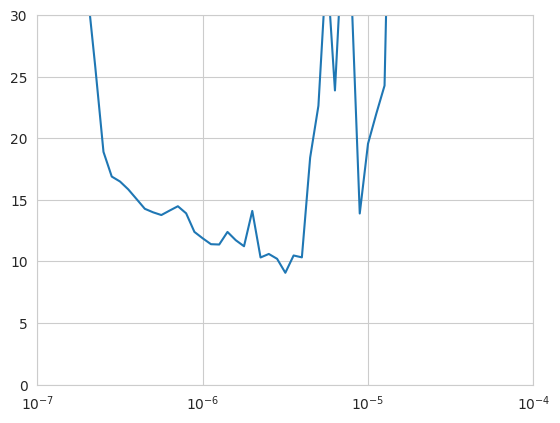

In [ ]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,1e-4,0,30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size,batch_size=128)
valid_set = window_dataset(X_valid,window_size,batch_size=128)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",
                                                  save_best_only=True)

In [ ]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 132ms/step - loss: 138.8266 - mae: 139.3266 - val_loss: 69.0948 - val_mae: 69.5948
Epoch 2/500
8/8 [==============================] - 1s 67ms/step - loss: 62.8155 - mae: 63.3152 - val_loss: 20.9289 - val_mae: 21.4239
Epoch 3/500
8/8 [==============================] - 1s 69ms/step - loss: 35.7806 - mae: 36.2766 - val_loss: 41.9912 - val_mae: 42.4912
Epoch 4/500
8/8 [==============================] - 1s 73ms/step - loss: 14.9047 - mae: 15.3979 - val_loss: 17.1313 - val_mae: 17.6244
Epoch 5/500
8/8 [==============================] - 1s 76ms/step - loss: 13.8624 - mae: 14.3512 - val_loss: 11.0143 - val_mae: 11.5079
Epoch 6/500
8/8 [==============================] - 1s 72ms/step - loss: 16.1582 - mae: 16.6523 - val_loss: 10.6538 - val_mae: 11.1467
Epoch 7/500
8/8 [==============================] - 1s 65ms/step - loss: 17.7832 - mae: 18.2774 - val_loss: 22.3724 - val_mae: 22.8724
Epoch 8/500
8/8 [==============================] - 1s 72ms/

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
rnn_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 1s 18ms/step


7.0132985

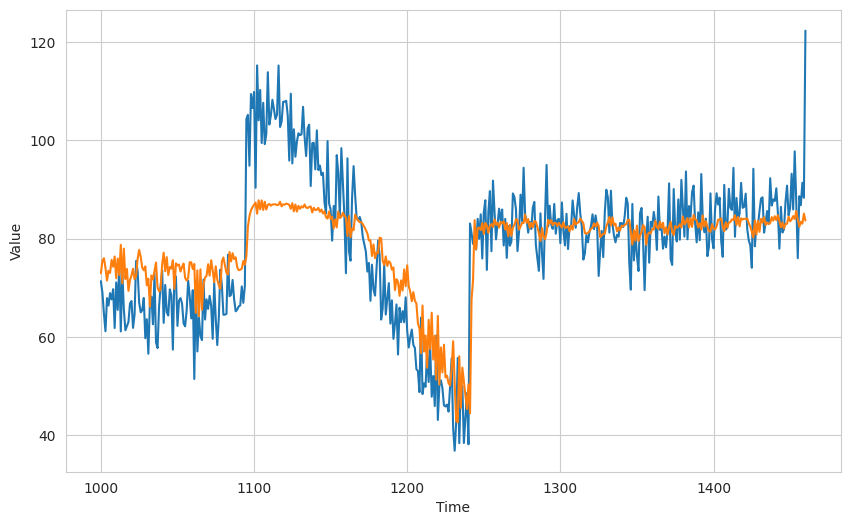

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)
print('\n')
keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy()

In [ ]:
# Sequence_to_Sequence

In [ ]:
def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
for X_batch,Y_batch in seq2_seq_window_dataset(tf.range(10),3,batch_size=1):
    print("X : ",X_batch.numpy())
    print("Y : ",Y_batch.numpy())

X :  [[[4]
  [5]
  [6]]]
Y :  [[[5]
  [6]
  [7]]]
X :  [[[1]
  [2]
  [3]]]
Y :  [[[2]
  [3]
  [4]]]
X :  [[[0]
  [1]
  [2]]]
Y :  [[[1]
  [2]
  [3]]]
X :  [[[5]
  [6]
  [7]]]
Y :  [[[6]
  [7]
  [8]]]
X :  [[[2]
  [3]
  [4]]]
Y :  [[[3]
  [4]
  [5]]]
X :  [[[6]
  [7]
  [8]]]
Y :  [[[7]
  [8]
  [9]]]
X :  [[[3]
  [4]
  [5]]]
Y :  [[[4]
  [5]
  [6]]]


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/30))

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [ ]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 46ms/step - loss: 138.6450 - mae: 139.1449 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 50ms/step - loss: 97.0487 - mae: 97.5486 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 1s 78ms/step - loss: 32.0651 - mae: 32.5619 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 1s 73ms/step - loss: 28.9515 - mae: 29.4506 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 1s 43ms/step - loss: 16.4817 - mae: 16.9751 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 1s 45ms/step - loss: 15.0898 - mae: 15.5815 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 42ms/step - loss: 13.6673 - mae: 14.1561 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 43ms/step - loss: 12.8506 - mae: 13.3389 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 42ms/step - loss: 12.3744 - mae: 12.8609 - lr: 1

(1e-07, 0.0001, 0.0, 30.0)

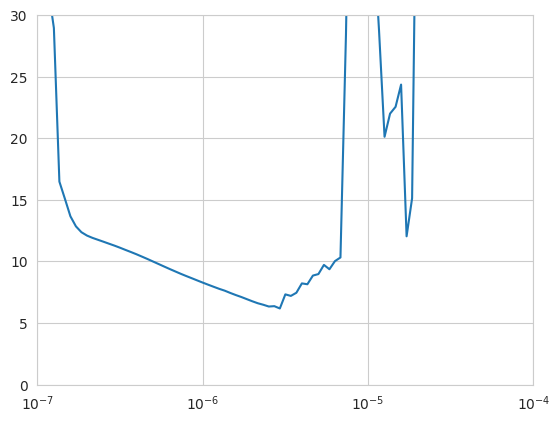

In [ ]:
plt.semilogx(history.history['lr'],history.history["loss"])
plt.axis([1e-7,1e-4,0,30])

In [ ]:
# Second

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 4s 203ms/step - loss: 29.5893 - mae: 30.0851 - val_loss: 31.3851 - val_mae: 31.8844
Epoch 2/500
8/8 [==============================] - 1s 103ms/step - loss: 22.5445 - mae: 23.0378 - val_loss: 21.7186 - val_mae: 22.2164
Epoch 3/500
8/8 [==============================] - 1s 65ms/step - loss: 18.9622 - mae: 19.4542 - val_loss: 17.8772 - val_mae: 18.3732
Epoch 4/500
8/8 [==============================] - 1s 69ms/step - loss: 15.9631 - mae: 16.4527 - val_loss: 17.2737 - val_mae: 17.7699
Epoch 5/500
8/8 [==============================] - 1s 67ms/step - loss: 13.9009 - mae: 14.3890 - val_loss: 14.3983 - val_mae: 14.8906
Epoch 6/500
8/8 [==============================] - 1s 69ms/step - loss: 12.2842 - mae: 12.7705 - val_loss: 11.7295 - val_mae: 12.2222
Epoch 7/500
8/8 [==============================] - 1s 114ms/step - loss: 11.0062 - mae: 11.4919 - val_loss: 10.8609 - val_mae: 11.3521
Epoch 8/500
8/8 [==============================] - 1s 88ms/

In [ ]:
rnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

45/45 [==============================] - 1s 12ms/step


In [ ]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

5.1745744




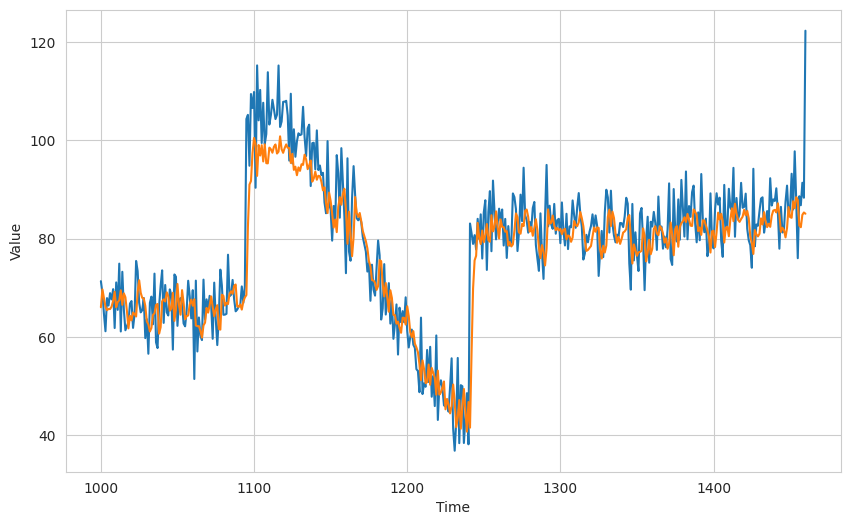

In [ ]:
print(keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy())
print('\n')
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)


In [ ]:
# StateFull RNN

In [ ]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
for X_batch,Y_batch in sequential_window_dataset(tf.range(10),3):
    print(X_batch.numpy(),Y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [ ]:
class RestStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/30))

In [ ]:
reset_states = RestStatesCallback()

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [ ]:
history = model.fit(train_set,epochs=100,
                   callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 3s 14ms/step - loss: 17.0365 - mae: 17.5303 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 14ms/step - loss: 16.5884 - mae: 17.0790 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 13ms/step - loss: 13.0207 - mae: 13.5089 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 13ms/step - loss: 12.8734 - mae: 13.3597 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 11.8092 - mae: 12.2937 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 11.2373 - mae: 11.7241 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 10.8388 - mae: 11.3227 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 10.5712 - mae: 11.0561 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 12ms/step - loss: 10.4136 - mae:

In [ ]:
#model = keras.models.load_model("my_checkpoint.h5")
#model.reset_states()

In [ ]:
model.reset_states()
rnn_forecast =model.predict(series[...,np.newaxis: ,np.newaxis],window_size)
rnn_forecast = rnn_forecast[0, split_time -1 :-1, 0]


TypeError: ignored

In [ ]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

IndexError: ignored

In [ ]:
rnn_forecast.shape

(0,)

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)